<a href="https://colab.research.google.com/github/tvaditya/intro_ds_and_ml/blob/main/%5BT_V_Aditya%5DChurn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

*by Tantravahi Aditya*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [64]:
# importar os pacotes necessários
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

df2 = df.copy()
# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [65]:
df.shape

(7043, 21)

##  Análise exploratória dos dados

Vamos explorar o dataset com o objetivo de entender alguns features.

In [66]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


Acima vamos que 16% das pessoas são Senior Citizens e que os clientes ficam em media 32 meses no plano e gastam 64$ por mês.

Óbvio que tem vários planos e várias mensalidades associadas que sabemos devido ao valor alto do desvio padrão.

In [67]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Vemos também muitos features categoricos que irão necessitar de tratamento, alguns parecem ser binários , outros não.

In [68]:
# Verificar se temos dados faltando
df.isna().any()

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

Vemos que não temos nenhum dado faltante, já que o isna() retornou False em todas as colunas.

In [69]:
# Verificar os quantos valores únicos temos por feature
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

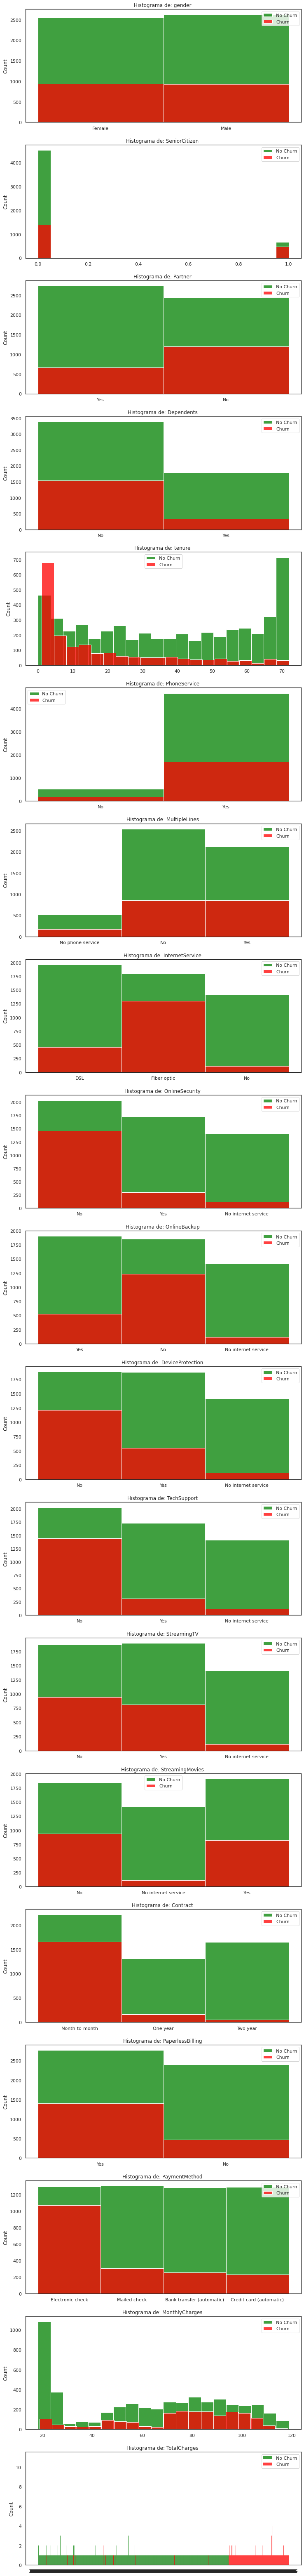

In [70]:
# Fazer um histograma de cada coluna separados em churn e não churn

features = df.iloc[:,1:20].columns
plt.figure(figsize=(12,19*6))
gs = gridspec.GridSpec(19, 1)
for idx, col in enumerate(df[features]):
 ax = plt.subplot(gs[idx])
 sns.histplot(df[col][df.Churn == 'No'], bins=20, color="green", kde=False, stat='count')
 sns.histplot(df[col][df.Churn == 'Yes'], bins=20, color="red", kde=False, stat='count')
 ax.set_xlabel("")
 ax.set_title(f"Histograma de: {str(col)} ")
 ax.legend(labels=['No Churn', 'Churn'])
plt.show()



In [71]:
# Vamos fazer um label encoding para features com ate 2 valores únicos( dados que são binários)

le = LabelEncoder()

le_count = 0
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
            print(f"A coluna {col} foi codificado")
print(f"Um total de {le_count} foram codificados")

A coluna gender foi codificado
A coluna Partner foi codificado
A coluna Dependents foi codificado
A coluna PhoneService foi codificado
A coluna PaperlessBilling foi codificado
A coluna Churn foi codificado
Um total de 6 foram codificados


Vamos analisar as correlações agora com o churn , nosso target

Text(0.5, 1.0, 'Correlação com o Churn Rate \n')

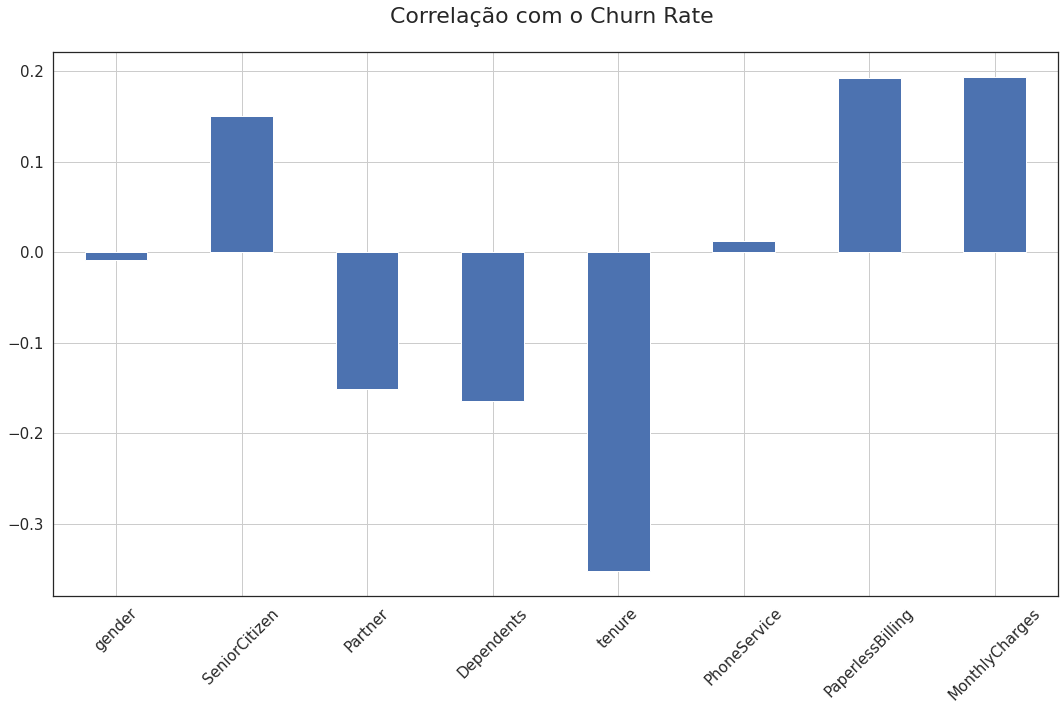

In [72]:
corrs = df.corrwith(df.Churn)
corrs = corrs[corrs != 1]

corrs.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
       # color = '#ec838a',
        rot = 45, grid = True)

plt.title('Correlação com o Churn Rate \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

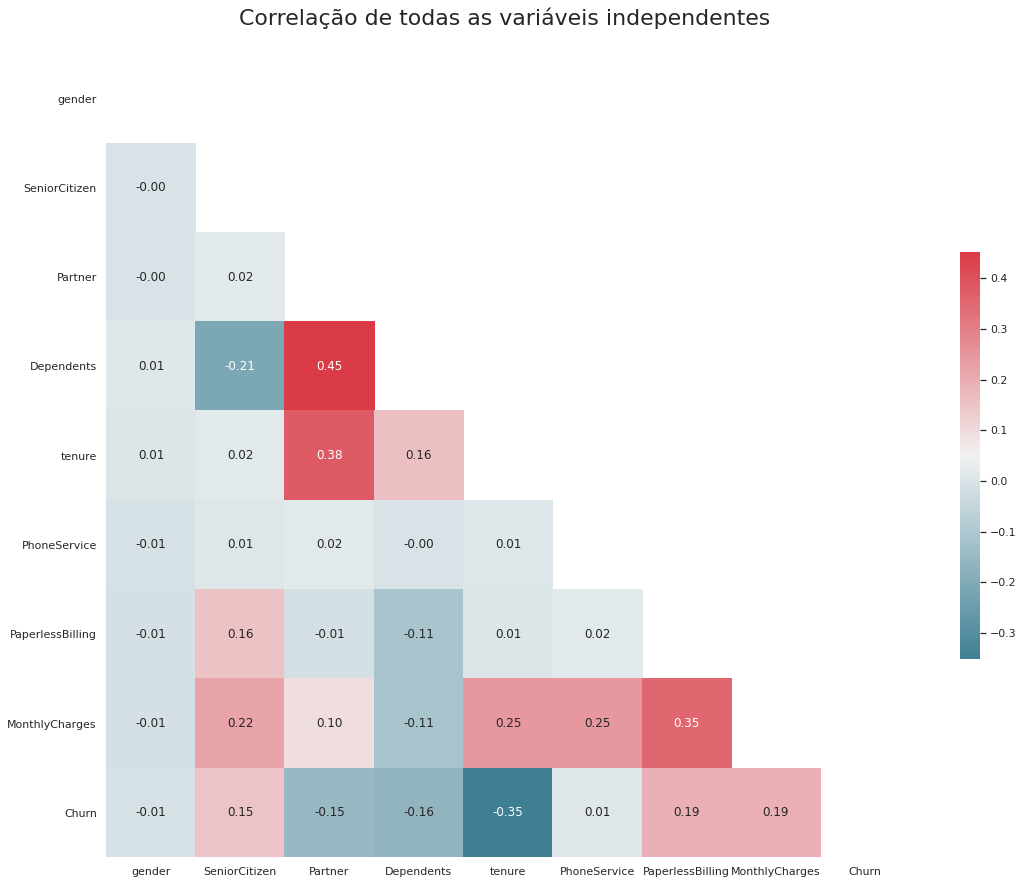

In [73]:
sns.set(style="white")
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlação de todas as variáveis independentes \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")
sns.heatmap(corr, mask=mask, cmap=cmap, fmt='.2f', square=True, linecolor='white', annot=True, cbar_kws={"shrink": .5});

In [74]:
df.Churn.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

Do total de 7043 temos apenas 1869 churns mostrando que o conjunto é desbalanceado.

Vamos agora criar dummies com o resto das variáveis categóricas

In [75]:
customerID = df.customerID

df = df.drop(columns="customerID")
df = pd.get_dummies(df)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,TotalCharges_973.35,TotalCharges_973.45,TotalCharges_973.55,TotalCharges_973.65,TotalCharges_973.95,TotalCharges_978,TotalCharges_978.6,TotalCharges_979.05,TotalCharges_979.5,TotalCharges_98.35,TotalCharges_98.5,TotalCharges_980.35,TotalCharges_981.45,TotalCharges_982.95,TotalCharges_985.05,TotalCharges_987.95,TotalCharges_989.05,TotalCharges_989.45,TotalCharges_99.45,TotalCharges_99.6,TotalCharges_99.75,TotalCharges_99.95,TotalCharges_990.3,TotalCharges_990.45,TotalCharges_990.85,TotalCharges_990.9,TotalCharges_992.7,TotalCharges_993.15,TotalCharges_994.55,TotalCharges_994.8,TotalCharges_995.35,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9
0,0,0,1,0,1,0,1,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,34,1,0,56.95,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,2,1,1,53.85,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,45,0,0,42.30,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,1,1,70.70,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Vemos que temos 6571 colunas agora. Se olharmos abaixo vemos que existe um campo chamado totalCharges cujso valores são numéricos mas estão como categoricos , vamos corrigir isso.

In [76]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'Churn',
       'MultipleLines_No',
       ...
       'TotalCharges_995.35', 'TotalCharges_996.45', 'TotalCharges_996.85',
       'TotalCharges_996.95', 'TotalCharges_997.65', 'TotalCharges_997.75',
       'TotalCharges_998.1', 'TotalCharges_999.45', 'TotalCharges_999.8',
       'TotalCharges_999.9'],
      dtype='object', length=6571)

Correção do campo TotalCharges, conversão para númerico.

In [77]:
# Funçao que irá converter para float
def converter_str_float(entrada):
    """
    Converte um objeto do tipo string em float.

    # Arguments
        entrada: string, string da coluna TotalCharges.

    # Returns
        Valor convertido em float, caso permita a conversão.
        NaN, caso o valor não seja apropriado.
    """

    try:
        return float(entrada)
    except ValueError:
        return np.nan

In [78]:
le = LabelEncoder()

le_count = 0
for col in df2.columns[1:]:
    if df2[col].dtype == 'object':
        if len(list(df2[col].unique())) <= 2:
            le.fit(df2[col])
            df2[col] = le.transform(df2[col])
            le_count += 1
            print(f"A coluna {col} foi codificado")
print(f"Um total de {le_count} foram codificados")

A coluna gender foi codificado
A coluna Partner foi codificado
A coluna Dependents foi codificado
A coluna PhoneService foi codificado
A coluna PaperlessBilling foi codificado
A coluna Churn foi codificado
Um total de 6 foram codificados


In [79]:
df2["TotalCharges"] = df2["TotalCharges"].apply(converter_str_float)

In [80]:
df2 = df2.drop(columns="customerID")
df2 = pd.get_dummies(df2)
print(df2.shape)
df2.head()

(7043, 41)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


In [81]:
# Verificar quantos NA temos
df2.TotalCharges.isna().sum()

11

In [82]:
# Preencher os NA com a média
df2.TotalCharges.fillna(df2.TotalCharges.mean(), inplace=True)

In [83]:
df2.TotalCharges.isna().sum()

0

### Algumas conclusões da nossa análise exploratória

Um peqeuno resumo do que descobrimos até aqui:

- Temos uma correlação forte e positiva com **Monthly Charges** e **Age**
- Temos uma correlação forte e negativa com **Partner**, **Dependents** e **Tenure**
- Vimos que a grande maioria dos clientes é jovem apenas 16% é cidadão sênior.
- Analisando o Tenure que é o tempo que o cliente usa o serviço vemos abaixo de 10 meses é onde está concentrado o nosso maior número de churns.
- Clientes com contratos mensais tendem a fazer mais churn que os clientes com contratos anuais.


In [84]:
df2.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,2283.300441,0.265370,0.481329,0.096834,0.421837,0.343746,0.439585,0.216669,0.496663,0.216669,0.286668,0.438450,0.216669,0.344881,0.439443,0.216669,0.343888,0.493114,0.216669,0.290217,0.398978,0.216669,0.384353,0.395428,0.216669,0.387903,0.550192,0.209144,0.240664,0.219225,0.216101,0.335794,0.228880
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,2265.000258,0.441561,0.499687,0.295752,0.493888,0.474991,0.496372,0.412004,0.500024,0.412004,0.452237,0.496232,0.412004,0.475363,0.496355,0.412004,0.475038,0.499988,0.412004,0.453895,0.489723,0.412004,0.486477,0.488977,0.412004,0.487307,0.497510,0.406726,0.427517,0.413751,0.411613,0.472301,0.420141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,402.225000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,1400.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,3786.600000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Acima vemos que montlhyCharges, tenure e totalCharges estão com um valor muito alto portanto seria bom fazer um feature scaling neles.

In [85]:
from sklearn.preprocessing import StandardScaler

In [86]:
df2.tenure = StandardScaler().fit_transform(df2[['tenure']])
df2.MonthlyCharges = StandardScaler().fit_transform(df2[['MonthlyCharges']])
df2.TotalCharges = StandardScaler().fit_transform(df2[['TotalCharges']])
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1.277445,0,1,-1.160323,-0.994971,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0.066327,1,0,-0.259629,-0.173876,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,-1.236724,1,1,-0.362660,-0.960399,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,0.514251,0,0,-0.746535,-0.195400,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,-1.236724,1,1,0.197365,-0.941193,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


## Analisando classificadores de Machine Learning

A idéia aqui é testar o desempenho de vários classificadores e no fim optar por um deles.

In [87]:
# Separar o target do conjunto de dados
target = df2.Churn

In [88]:
dataset = df2.drop(columns='Churn')

In [89]:
# Importar classficadores
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [90]:
# Separar em treino e teste
X_train, X_test, y_train, y_test = train_test_split(dataset, target, stratify=target, test_size=0.2, random_state=2021)

Iremos criar dicionários com os modelos a serem utilizados junto com os paramentros que utilizaremos no nosso gridsearch. 

Em seguida criaremos um método que irá executar esses classificadores e gerar o modelos.

In [91]:
models1 = {
    'XGBoostClassifier': XGBClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC()
}

In [92]:
params1 = {
    'XGBoostClassifier': { 'n_estimators': [16, 32, 64, 128] },
    'RandomForestClassifier': { 'n_estimators': [16, 32, 64, 128] },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32, 64, 128] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32, 64, 128], 'learning_rate': [0.8, 1.0] },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
}


Abaixo uma classe que contém os métodos que vão gerar os modelos.

In [93]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

Treinaremos o modelo e faremos o fit primeiro como métrica utilizaremos o F1-score segundo o recall, apenas para ver se daria alguam diferença. O recall é a métrica que nos interessa.

In [94]:
# Fit com o F1-score
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring='f1', n_jobs=2)


Running GridSearchCV for XGBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    4.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:    8.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for SVC.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:   18.3s finished


In [95]:
helper1.score_summary(sort_by='max_score')


XGBoostClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
SVC


,estimator,min_score,mean_score,max_score,std_score,n_estimators,learning_rate,C,kernel,gamma
2,XGBoostClassifier,0.587031,0.59644,0.606593,0.00800373,64,NaN,NaN,NaN,NaN
21,SVC,0.558242,0.586318,0.605061,0.0202211,NaN,NaN,10,linear,NaN
3,XGBoostClassifier,0.58613,0.595617,0.604651,0.00756811,128,NaN,NaN,NaN,NaN
20,SVC,0.557269,0.584968,0.601985,0.0197566,NaN,NaN,1,linear,NaN
10,AdaBoostClassifier,0.582278,0.590075,0.600219,0.00750983,64,NaN,NaN,NaN,NaN
11,AdaBoostClassifier,0.585946,0.591237,0.59846,0.00528814,128,NaN,NaN,NaN,NaN
1,XGBoostClassifier,0.545882,0.576779,0.598407,0.0224223,32,NaN,NaN,NaN,NaN
24,SVC,0.5625,0.583322,0.5963,0.014872,NaN,NaN,10,rbf,0.001
9,AdaBoostClassifier,0.568075,0.580118,0.590858,0.00934674,32,NaN,NaN,NaN,NaN
8,AdaBoostClassifier,0.583808,0.584308,0.584946,0.000474729,16,NaN,NaN,NaN,NaN


In [96]:
helper2 = EstimatorSelectionHelper(models1, params1)
helper2.fit(X_train, y_train, scoring='recall', n_jobs=2)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for XGBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:    8.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for SVC.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:   18.5s finished


In [97]:
helper2.score_summary(sort_by='max_score')

XGBoostClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
SVC


,estimator,min_score,mean_score,max_score,std_score,n_estimators,learning_rate,C,kernel,gamma
2,XGBoostClassifier,0.517034,0.533121,0.554217,0.0155875,64,NaN,NaN,NaN,NaN
21,SVC,0.51004,0.537116,0.552209,0.0191874,NaN,NaN,10,linear,NaN
10,AdaBoostClassifier,0.508032,0.535109,0.550201,0.0191882,64,NaN,NaN,NaN,NaN
24,SVC,0.506024,0.526406,0.549098,0.0176606,NaN,NaN,10,rbf,0.001
20,SVC,0.508032,0.535108,0.549098,0.0191489,NaN,NaN,1,linear,NaN
3,XGBoostClassifier,0.52505,0.540479,0.548193,0.0109096,128,NaN,NaN,NaN,NaN
11,AdaBoostClassifier,0.52008,0.53645,0.546185,0.0116443,128,NaN,NaN,NaN,NaN
8,AdaBoostClassifier,0.514056,0.528417,0.54509,0.0127746,16,NaN,NaN,NaN,NaN
12,GradientBoostingClassifier,0.513026,0.530446,0.544177,0.0129821,16,0.8,NaN,NaN,NaN
7,RandomForestClassifier,0.459839,0.489646,0.540161,0.0359119,128,NaN,NaN,NaN,NaN


Em ambos os casos vemos que o XGBoost foi o melhor classifcador mas os scores estão relativamente baixos, talvez pq o conjunto esteja desbalanceado, vamos tratar isso.

### Tratando dados desbalanceados

Vamos tratar os dados balenceadoes usando o random under sampler.

In [98]:
from imblearn.under_sampling import RandomUnderSampler

In [99]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=2021, replacement=True)
X_resampled_under, y_resampled_under =rus.fit_resample(X_train, y_train)
print(f"X_resampled_under {X_resampled_under.shape} ")
print(f"Y_resampled_under {y_resampled_under.shape} ")
print(f"X_train {X_train.shape} ")
print(f"Y_train {y_train.shape} ")

X_resampled_under (2990, 40) 
Y_resampled_under (2990,) 
X_train (5634, 40) 
Y_train (5634,) 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Com os desbalanceamento tratado vamos gerar novos modelos

### Novos modelos com desbalanceamento tratado

In [100]:
helper3 = EstimatorSelectionHelper(models1, params1)
helper3.fit(X_resampled_under, y_resampled_under, scoring='recall', n_jobs=2)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for XGBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:    5.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for SVC.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=2)]: Done  18 out of  18 | elapsed:    7.1s finished


In [101]:
helper3.score_summary(sort_by='max_score')

XGBoostClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
SVC


,estimator,min_score,mean_score,max_score,std_score,n_estimators,learning_rate,C,kernel,gamma
23,SVC,0.819639,0.84751,0.873494,0.0220266,NaN,NaN,1,rbf,0.0001
3,XGBoostClassifier,0.781563,0.801351,0.831325,0.0215544,128,NaN,NaN,NaN,NaN
8,AdaBoostClassifier,0.789157,0.808698,0.831325,0.0173531,16,NaN,NaN,NaN,NaN
2,XGBoostClassifier,0.773092,0.795326,0.829317,0.0244132,64,NaN,NaN,NaN,NaN
21,SVC,0.793587,0.807367,0.827309,0.0144401,NaN,NaN,10,linear,NaN
20,SVC,0.793587,0.807367,0.827309,0.0144401,NaN,NaN,1,linear,NaN
1,XGBoostClassifier,0.7751,0.797996,0.825301,0.0207302,32,NaN,NaN,NaN,NaN
24,SVC,0.795181,0.806026,0.825301,0.0136654,NaN,NaN,10,rbf,0.001
25,SVC,0.801205,0.808031,0.821285,0.00937346,NaN,NaN,10,rbf,0.0001
22,SVC,0.797189,0.806692,0.821285,0.0104748,NaN,NaN,1,rbf,0.001


Vemos uma melhora significante nos recalls veremos o mesmo se fizermos o f1-score. A partir de agora vamos seguir com o XGBoost e ajustar os hiperparametors dele até acharmos um modelos de melhor recall ou f1-score.

## Ajuste de hiperparametros

In [102]:
# model_final = {
#     'XGBoostClassifier': XGBClassifier(),
# }

# params_final = {
#     'XGBoostClassifier': [
#                           {
#                           'n_estimators': range(0,1000,50),
#                           'max_depth': range(1,8,1),
#                           'min_child_weight': range(1,5,1),
#                           'gamma':[i/10.0 for i in range(0,5)],
#                           'learning_rate':[0.001, 0.01, 0.1, 1]
#                            }
#                           ]
    
# }

In [103]:
model_final = XGBClassifier()

In [61]:
params_final ={
                          'n_estimators': range(0,128,16),
                          'max_depth': range(1,8,2),
                          'min_child_weight': range(1,5,1),
                          'gamma':[i/10.0 for i in range(0,5)],
                          'learning_rate':[0.001, 0.01, 0.1, 1]
                           }

In [62]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

kfold = StratifiedKFold(n_splits=5, shuffle=True)

# Identificar os melhores parametros
grid_search = GridSearchCV(model_final, params_final, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_resampled_under, y_resampled_under)

print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8849498327759197 para {'gamma': 0.0, 'learning_rate': 0.001, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 16}


Agora já temos o conjunto de hiperparametros com o melhor recall vamos fazer as previsões

In [105]:
xgb = XGBClassifier(gamma=0.0, learning_rate=0.001, n_estimators=16, max_depth=1, min_child_weight=1 )
xgb.fit(X_resampled_under, y_resampled_under)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.0,
              learning_rate=0.001, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=None, n_estimators=16, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [107]:
y_pred = xgb.predict(X_test.values)

# Se tiver um mismatch error só seguir os passos descritos no link abaixo
# https://stackoverflow.com/questions/42338972/valueerror-feature-names-mismatch-in-xgboost-in-the-predict-function

In [109]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report

In [110]:
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

AUC: 0.7318



In [113]:
print(classification_report(y_test, y_pred, target_names=['No churn', 'Churn']))

              precision    recall  f1-score   support

    No churn       0.93      0.58      0.71      1035
       Churn       0.43      0.89      0.58       374

    accuracy                           0.66      1409
   macro avg       0.68      0.73      0.65      1409
weighted avg       0.80      0.66      0.68      1409



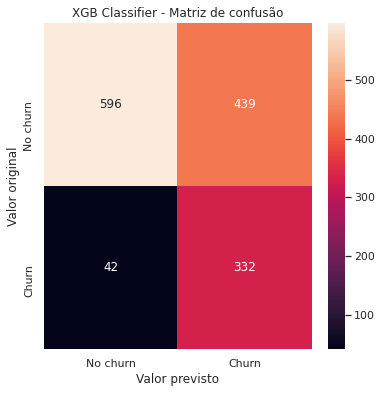

In [112]:
labels= ['No churn', 'Churn'] 
conf_matrix=confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(6, 6)) 
sns.heatmap(conf_matrix, xticklabels= labels, yticklabels= labels, annot=True, fmt="d")
plt.title("XGB Classifier - Matriz de confusão") 
plt.ylabel('Valor original') 
plt.xlabel('Valor previsto') 
plt.show()

Vemos então que temos um recall de 89% o que é bom para esse caso

## Conclusão

Testamos vários bons modelos para casos de classificação e escolhemos o melhor deles segundo a métrica de recall.

Fizemos o tratamentos do desbalanceamento( podemos tentar outras técnicas também).

Mas já temos aqui um ótimo modelo que obviamente pode ser melhorado, testando mais algoritmos entre outras técnicas.